# Import Packages

In [1]:
# Standard packages
import numpy as np
import pandas as pd
import math
import time
from scipy.integrate import trapz
from scipy import stats

# Plotting packages
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

# User-defined notebooks
import animation_utility as animation

# Set table display configuration
pd.set_option('display.max_columns', None)

# Functions

In [2]:
def parse_play_description(string):
    valid_plays = [
    'pass short right',
    'pass short left',
    'up the middle',
    'pass short middle',
    'left tackle',
    'left end',
    'right tackle',
    'right guard',
    'left guard',
    'right end',
    'pass deep right',
    'pass deep left',
    'pass deep middle',
    'scrambles right end',
    'scrambles left end',
    'scrambles up the middle',
    'scrambles right tackle',
    'scrambles left tackle',
    'scrambles left guard',
    'scrambles right guard',
    'FUMBLES']
    for item in valid_plays:
        if item in string:
            if item == 'FUMBLES':
                item = "broken play"
            return item
    return '**unknown_play**'

def round_to_nearest_025(value):
    return np.ceil(value / 0.25) * 0.25

def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180
    
def harmonize_play_direction(df: pd.DataFrame):
    result_df = df.copy(deep=True)
    mask = result_df['playDirection']=='left'
    result_df.loc[mask,'o'] = result_df.loc[mask,'o'].apply(reverse_deg)
    result_df.loc[mask,'dir'] = result_df.loc[mask,'dir'].apply(reverse_deg)
    result_df.loc[mask,'x'] = result_df.loc[mask,'x'].apply(lambda x: 120 - x)
    result_df.loc[mask,'y'] = result_df.loc[mask,'y'].apply(lambda y: 160/3 - y)
    return result_df

def calc_approach_probability(df):
    cols = list(df.columns)
    results = pd.DataFrame(
        data=np.zeros((len(cols),2)),
        columns=['opportunities','successes'],
        index=cols
    )
    df = df.reset_index(drop=True)
    for col in cols:
        mask1 = df[col] > 0
        mask2 = df[cols[0]] > 0
        results.loc[col,'opportunities'] = mask1.sum()
        results.loc[col,'successes'] = (mask1 & mask2).sum()
    results['Pt'] = results['successes']/results['opportunities']
    results['current_dist'] = results.index
    results = results.reset_index(drop=True)
    return results

def clip_play(df):
    '''
    Function to clip off parts of play after tackle, out of bounds, etc
    '''
    # Set end events
    event_list = ['tackle','out_of_bounds','fumble','touchdown','fumble_defense_recovered','qb_slide','fumble_offense_recovered','safety']
    # Search for end events
    e_mask = df['event'].isin(event_list)
    # If valid end event is found, truncate df
    if e_mask.sum() > 0:
        return df[df['frameId']<=df.loc[e_mask,'frameId'].min()].reset_index(drop=True)

# Import Data

In [3]:
# Load data
tackles = pd.read_csv('data/tackles.csv')
plays = pd.read_csv('data/plays.csv')
players = pd.read_csv('data/players.csv')
games = pd.read_csv('data/games.csv')

# Add play description
plays['play_type'] = plays['playDescription'].apply(lambda x: parse_play_description(x))

# Set run and pass plays
run_plays = ['left end', 'up the middle', 'left guard','right guard','left tackle','right tackle','right end']
pass_plays = ['pass short right','pass short left','pass short middle','pass deep right','pass deep left','pass deep middle']

# Crunch Data for All Games

## Compile Data for Proximity Transition Probabilities

In [4]:
# Setup loop
dist_counts = pd.DataFrame()
weeks = list(range(1,10))
for week in weeks:
    
    print(f'Processing Week {week} data...')
    timer = time.time()
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOAD CURRENT WEEK'S TRACKING DATA
    tracking_data = pd.read_csv(f'data/tracking_week_{week}.csv')
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # PROCESS TACKING DATA
    
    # Typecast time feature
    tracking_data['time'] = pd.to_datetime(tracking_data['time'])
    # Get align all plays to be in the same direction
    tracking_data = harmonize_play_direction(tracking_data)
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ADD "PLAYS" & "TACKLES" DATA
    
    # Add dfs together
    tracking_data = tracking_data.merge(
        how='left', 
        on=['gameId','playId'], 
        right=plays
    )
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # PROCESS DATA FOR METRIC COMPILATION
    ballcarrier_df = tracking_data[tracking_data['nflId']==tracking_data['ballCarrierId']].reset_index(drop=True)
    tracking_data = tracking_data.merge(
        how='left',
        on=['gameId','playId','frameId'],
        right=ballcarrier_df[['gameId','playId','frameId','x','y']],
        suffixes=('','_bc')
    )
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # COMPILE PURSUIT METRICS
    tracking_data = tracking_data[tracking_data['club']==tracking_data['defensiveTeam']].reset_index(drop=True)
    tracking_data['dist_x'] = (tracking_data['x']-tracking_data['x_bc']).abs()
    tracking_data['dist_y'] = (tracking_data['y']-tracking_data['y_bc']).abs()
    tracking_data['vx'] = tracking_data['s'] * (tracking_data['o']*math.pi/182).apply(math.sin)
    tracking_data['vy'] = tracking_data['s'] * (tracking_data['o']*math.pi/180).apply(math.cos)
    tracking_data['dist'] = (tracking_data['dist_x']**2 + tracking_data['dist_y']**2)**0.5
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CLIP PLAYS
    tracking_data = tracking_data.groupby(['gameId','playId']).apply(clip_play).reset_index(drop=True)
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CALCULATE TACKLE PROBABILITY
    print(f'\tComputing Week {week} tackle probabilities...')
    
    # Add distance threshold columns to tracking df
    col_list = []
    range_ = np.arange(0.75,15.25,0.25)
    for i in range_:
        col = str(i)
        col_list.append(col)
        tracking_data[col] = (tracking_data['dist'] <= i).astype(int)
    
    # Determine how frequently player gets close to ball carrier, then merge in tackling data
    tdf = tracking_data.groupby(['nflId','gameId','playId'])[col_list].max().reset_index()
    tdf = tdf.merge(
        how='left',
        on=['nflId','gameId','playId'],
        right=tackles[['nflId','gameId','playId','tackle','assist','forcedFumble','pff_missedTackle']]
    ).merge(
        how='left',
        on=['gameId','playId'],
        right=plays[['gameId','playId','passProbability','play_type','offenseFormation','defendersInTheBox']]
    )
    tdf['week'] = week
    dist_counts = tdf if dist_counts.empty else pd.concat([dist_counts, tdf],axis=0).reset_index(drop=True)
    
    # Print loop runtime
    print(f'\tWeek {week} runtime: {(time.time()-timer)/60:0.2f} min')
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CLEAN UP & SHOW RESULTS

# Post-process & show tackle outcome data
dist_counts = dist_counts.merge(
    how='left',
    on='nflId',
    right=players[['nflId','displayName','position']]
)

print(len(dist_counts))

Processing Week 1 data...
	Computing Week 1 tackle probabilities...
	Week 1 runtime: 0.32 min
Processing Week 2 data...
	Computing Week 2 tackle probabilities...
	Week 2 runtime: 0.27 min
Processing Week 3 data...
	Computing Week 3 tackle probabilities...
	Week 3 runtime: 0.32 min
Processing Week 4 data...
	Computing Week 4 tackle probabilities...
	Week 4 runtime: 0.37 min
Processing Week 5 data...
	Computing Week 5 tackle probabilities...
	Week 5 runtime: 0.37 min
Processing Week 6 data...
	Computing Week 6 tackle probabilities...
	Week 6 runtime: 0.26 min
Processing Week 7 data...
	Computing Week 7 tackle probabilities...
	Week 7 runtime: 0.36 min
Processing Week 8 data...
	Computing Week 8 tackle probabilities...
	Week 8 runtime: 0.31 min
Processing Week 9 data...
	Computing Week 9 tackle probabilities...
	Week 9 runtime: 0.22 min
137302


## Compute Proximitiy Transition Probability Matrix

In [5]:
# Categorize plays by pass probability
dist_counts.loc[(dist_counts['passProbability']<=0.50),'run_pass_guess'] = 'run likely'
dist_counts.loc[(dist_counts['passProbability']>0.50),'run_pass_guess'] = 'pass likely'

# Truncate to run plays
dist_counts = dist_counts[dist_counts['play_type'].isin(run_plays)].reset_index(drop=True)
dist_counts['week'] = (dist_counts['week']>5).astype(int)

# Organize df
start = time.time()
cols = np.arange(0.75,15.25,0.25)
cols = [str(i) for i in cols]

# Calculate transition probabilities
transition_matrix_position = dist_counts.groupby(['week','position','play_type','offenseFormation','run_pass_guess'])[cols].apply(calc_approach_probability).reset_index()
transition_matrix_position = transition_matrix_position.drop('level_5',axis=1)

# Typecast columns
transition_matrix_position[['current_dist','Pt']] = transition_matrix_position[['current_dist','Pt']].astype(float)

# Display results
print(f"runtime = {(time.time()-start)/60:0.2f} mins")

runtime = 1.18 mins


## Compute Expected Approach Probability for Each Player's Plays

In [6]:
# Set static variables
weeks = list(range(1,10))
# Initialize empty df
aaa_save_df = pd.DataFrame()
# Iterate through weeks
for week in weeks:  
    # Start timer
    print(f'Processing Week {week} data...')
    timer = time.time()
    
    # Load current week's tracking data
    tracking_data = pd.read_csv(f'data/tracking_week_{week}.csv')
    
    # Merge in play meta-data
    tracking_data = tracking_data.merge(
        how='left', 
        on=['gameId','playId'], 
        right=plays
    )
    
    # Merge in player data
    tracking_data = tracking_data.merge(
        how='left', 
        on=['nflId'], 
        right=players[['nflId','position']]
    )
    
    # Merge in meta-data about ballcarrier
    ballcarrier_df = tracking_data[tracking_data['nflId']==tracking_data['ballCarrierId']].reset_index(drop=True)
    tracking_data = tracking_data.merge(
        how='left',
        on=['gameId','playId','frameId'],
        right=ballcarrier_df[['gameId','playId','frameId','x','y']],
        suffixes=('','_bc')
    )
    
    # Calculate distance to ballcarrier
    tracking_data = tracking_data[tracking_data['club']==tracking_data['defensiveTeam']].reset_index(drop=True)
    tracking_data['dist_x'] = (tracking_data['x']-tracking_data['x_bc']).abs()
    tracking_data['dist_y'] = (tracking_data['y']-tracking_data['y_bc']).abs()
    tracking_data['dist'] = (tracking_data['dist_x']**2 + tracking_data['dist_y']**2)**0.5
    
    # Set run pass guess categorization
    tracking_data.loc[(tracking_data['passProbability']<=0.50),'run_pass_guess'] = 'run likely'
    tracking_data.loc[(tracking_data['passProbability']>0.50),'run_pass_guess'] = 'pass likely'
    
    # Grab each player's distance-to-ballcarrier for every play at the instant the "run start" event happens
    data_columns = ['nflId','displayName','position','gameId','playId',
                'offenseFormation','play_type','passProbability','run_pass_guess','dist','event']
    event_options = ['pass_arrived','run','handoff','run_pass_option']
    mask = tracking_data['event'].isin(event_options)
    tracking_data = tracking_data.loc[mask,data_columns].reset_index(drop=True)
    
    # Truncation tracking data to run plays only, rename columns as necessary
    mask = tracking_data['play_type'].isin(run_plays)
    tracking_data = tracking_data.loc[mask,data_columns].reset_index(drop=True)
    tracking_data = tracking_data.rename(columns={'dist':'current_dist'})

    # Match decimals up to lookup table by rounding to nearest 0.25 & truncating values > 15 to 15
    tracking_data['current_dist'] = tracking_data['current_dist'].apply(round_to_nearest_025)
    tracking_data.loc[tracking_data['current_dist']>15,'current_dist'] = 15

    # Fill empty pass probabilities
    tracking_data['passProbability'] = tracking_data['passProbability'].fillna(0.5)
    
    tracking_data['week'] = 0 if week<=5 else 1

    # Find probability from lookup table
    cur_df = tracking_data.merge(
        how='left',
        on=['week','position','play_type','offenseFormation','run_pass_guess','current_dist'],
        right=transition_matrix_position[['week','position','play_type','offenseFormation','run_pass_guess','current_dist','Pt']],
    )
    
    # Add to compilation df
    aaa_save_df = cur_df if aaa_save_df.empty else pd.concat([aaa_save_df, cur_df], axis=0).reset_index(drop=True)
    
    # Print loop runtime
    print(f'\tWeek {week} runtime: {(time.time()-timer)/60:0.2f} min')

# Rename columns
aaa_save_df = aaa_save_df.rename(columns={'current_dist':'dist0','Pt':'P_prox','offenseFormation':'play_formation'})
    
# Display results
aaa_save_df[['nflId','gameId','playId','dist0','P_prox']] = aaa_save_df[['nflId','gameId','playId','dist0','P_prox']].astype(float)
print(len(aaa_save_df))

Processing Week 1 data...
	Week 1 runtime: 0.14 min
Processing Week 2 data...
	Week 2 runtime: 0.13 min
Processing Week 3 data...
	Week 3 runtime: 0.13 min
Processing Week 4 data...
	Week 4 runtime: 0.14 min
Processing Week 5 data...
	Week 5 runtime: 0.15 min
Processing Week 6 data...
	Week 6 runtime: 0.11 min
Processing Week 7 data...
	Week 7 runtime: 0.12 min
Processing Week 8 data...
	Week 8 runtime: 0.13 min
Processing Week 9 data...
	Week 9 runtime: 0.10 min
75196


# Compile Results

## Approaches

In [7]:
# Create copy of data prior to doing calculations
aaa_df = aaa_save_df.copy(deep=True)

# Merge in tackle outcome data
aaa_df = aaa_df.merge(
    how='left',
    on=['nflId','gameId','playId'],
    right=dist_counts[['nflId','gameId','playId','1.0']].rename(columns={'1.0':'successful_approach'})
)

# Calculate Aproaches Above Average
aaa_df['AAA_i'] = aaa_df['successful_approach']*(1-aaa_df['P_prox']) - (1-aaa_df['successful_approach'])*aaa_df['P_prox']

# Filter data to just run plays
aaa_df = aaa_df[aaa_df['play_type'].isin(run_plays)].reset_index(drop=True)

# Sum up AAA
aaa_df_gb = aaa_df.groupby(['displayName','position','week'])['AAA_i'].sum()\
                    .reset_index().rename(columns={'AAA_i':'AAA'})

# Merge in # of plays
aaa_df_gb = aaa_df_gb.merge(
    how='left',
    on=['displayName','week'],
    right=aaa_df.groupby(['displayName','week'])['playId'].count().reset_index().rename(columns={'playId':'n_plays'})
)

# Merge in expected approach %
aaa_df_gb = aaa_df_gb.merge(
    how='left',
    on=['displayName','week'],
    right=aaa_df.groupby(['displayName','week'])['P_prox'].mean().reset_index().rename(columns={'P_prox':'exp_appr_pct'})
)

# Merge in # of successful approaches (calculation in previous cell is only null if player doesn't get w/in 0.75 yards)
aaa_df_gb = aaa_df_gb.merge(
    how='left',
    on=['displayName','week'],
    right=aaa_df.groupby(['displayName','week'])['successful_approach'].sum()\
                .reset_index().rename(columns={'successful_approach':'Successful Approaches'})
)

# Change expectation to %
aaa_df_gb['exp_appr_pct'] = aaa_df_gb['exp_appr_pct'] * 100

# Calculate actual approach %
aaa_df_gb['Approach %'] = aaa_df_gb['Successful Approaches'] / aaa_df_gb['n_plays'] * 100

# Calculate approach % added
aaa_df_gb['added_appr_pct'] =  aaa_df_gb['Approach %'] - aaa_df_gb['exp_appr_pct']

# Show results
display(aaa_df_gb[aaa_df_gb['displayName']=='Alex Singleton'])

,displayName,position,week,AAA,n_plays,exp_appr_pct,Successful Approaches,Approach %,added_appr_pct
48,Alex Singleton,OLB,0,11.819410,52,23.788490,23,44.230769,20.442279
49,Alex Singleton,OLB,1,12.501728,66,23.681179,31,46.969697,23.288518


## Run Stops

In [8]:
# Make a copy of the compiled data
run_stops_df = aaa_save_df.copy(deep=True)

# Merge in tackle outcome data (i.e., what happens when player gets w/in critical distance)
run_stops_df = run_stops_df.merge(
    how='left',
    on=['nflId','gameId','playId'],
    right=tackles[['nflId','gameId','playId','tackle','assist','pff_missedTackle']]
)

# Fill NAs
run_stops_df[['tackle','assist','pff_missedTackle']] = run_stops_df[['tackle','assist','pff_missedTackle']].fillna(0)

# Limit data to run plays where there is a tackle/assist
mask = (run_stops_df['play_type'].isin(run_plays))
run_stops_df = run_stops_df[mask].reset_index(drop=True)

# Sum by player
run_stops_df_gb = run_stops_df.groupby(['displayName','position','week'])[['tackle','assist','pff_missedTackle']].sum().reset_index()

# Show results
display(run_stops_df_gb[run_stops_df_gb['displayName']=='Alex Singleton'])

,displayName,position,week,tackle,assist,pff_missedTackle
48,Alex Singleton,OLB,0,5.0,9.0,0.0
49,Alex Singleton,OLB,1,12.0,6.0,4.0


## Expected Run Stops

In [9]:
# Create initial df from run_stops_df, then merge in approach info
ersp_pbp = run_stops_df.copy(deep=True)
ersp_pbp = ersp_pbp.merge(
    how='left',
    on=['nflId','gameId','playId'],
    right=dist_counts[['nflId','gameId','playId','1.0']]
)

# Compute run stops as a sum of the three fields
ersp_pbp['run_stops'] = ersp_pbp[['tackle','assist']].sum(axis=1)

# Limit computations to plays where defender approached ball carrier
ersp_pbp = ersp_pbp[ersp_pbp['1.0']>0].reset_index(drop=True)

# Determine expected run stop % for each play, formation, and defensive position
group_cols = ['position','play_formation','play_type']
ersp_map = ersp_pbp.groupby(group_cols)['run_stops'].sum().reset_index()\
            .merge(
    how='left',
    on=group_cols,
    right=ersp_pbp.groupby(group_cols)['playId'].count().reset_index().rename(columns={'playId':'n_opportunities'})
)
ersp_map['Expected Run Stop %'] = ersp_map['run_stops'] / ersp_map['n_opportunities']

# Merge expectations into play-by-play df
player_ersp = ersp_pbp.merge(
    how='left',
    on=['position','play_formation','play_type'],
    right=ersp_map[['position','play_formation','play_type','Expected Run Stop %']],
)

# Get mean exp run stop % for each player
player_ersp = player_ersp.groupby(['displayName','position','week'])['Expected Run Stop %'].mean().reset_index()
player_ersp['Expected Run Stop %'] = 100 * player_ersp['Expected Run Stop %']

# Rename columns
player_ersp = player_ersp.rename(columns={'displayName':'Player','position':'Position'})

# Show results
display(player_ersp[player_ersp['Player']=='Alex Singleton'])

,Player,Position,week,Expected Run Stop %
46,Alex Singleton,OLB,0,45.492530
47,Alex Singleton,OLB,1,47.960993


## Aggregate into Single Place

In [10]:
# Merge both tackling metrics into one dataset
adv_tackling_scoreboard = aaa_df_gb.merge(
    how='left',
    on=['displayName','position','week'],
    right=run_stops_df_gb,
)

# Format dataset
rename_dict = {
    'displayName':'Player',
    'position':'Position',
    'added_appr_pct':'Added Approach %',
    'exp_appr_pct':'Expected Approach %',
    'pff_missedTackle':'Missed Tackles',
    'tackle':'Tackles',
    'assist':'Assists',
    'uncredited_run_stops':'Uncredited Tackles',
    'n_plays':'# of Plays',
}
adv_tackling_scoreboard = adv_tackling_scoreboard.rename(columns=rename_dict)

# Check to make sure sums are correct
print(f"bad sums = {(adv_tackling_scoreboard[['Tackles','Assists']].sum(axis=1) > adv_tackling_scoreboard['Successful Approaches']).sum()}")

# Compute # of run stops
adv_tackling_scoreboard['Run Stops'] = adv_tackling_scoreboard['Tackles'] + 1.00 * adv_tackling_scoreboard['Assists']

# Compute rates
adv_tackling_scoreboard['Run Stop %'] = 100 * adv_tackling_scoreboard['Run Stops'] / adv_tackling_scoreboard['Successful Approaches']
adv_tackling_scoreboard['Missed Tackle %'] = 100 * adv_tackling_scoreboard['Missed Tackles'] / adv_tackling_scoreboard['Successful Approaches']

# Merge in previously calc'd expected run stop %
adv_tackling_scoreboard = adv_tackling_scoreboard.merge(
    how='left',
    on=['Player','Position','week'],
    right=player_ersp,
)

# Calculate expected missed tackle rate as mean value of position's rate & add back into main df
calc_cols = ['Missed Tackle %']
tr_expectation_df = adv_tackling_scoreboard.groupby(['Position'])[calc_cols].mean()\
                    .reset_index().rename(columns={
                    'Missed Tackle %':'Expected Missed Tackle %',
                })
adv_tackling_scoreboard = adv_tackling_scoreboard.merge(
    how='left',
    on='Position',
    right=tr_expectation_df
)

# Calculate Added-%'s
adv_tackling_scoreboard['Added Run Stop %'] = adv_tackling_scoreboard['Run Stop %'] - adv_tackling_scoreboard['Expected Run Stop %']
adv_tackling_scoreboard['Avoided Missed Tackle %'] = -1 * (adv_tackling_scoreboard['Missed Tackle %'] - adv_tackling_scoreboard['Expected Missed Tackle %'])

# Compute Run Stops Above Average
adv_tackling_scoreboard['RSOE'] = adv_tackling_scoreboard['Run Stops'] - \
            (adv_tackling_scoreboard['# of Plays'] * adv_tackling_scoreboard['Expected Approach %']/100 * adv_tackling_scoreboard['Expected Run Stop %']/100)
adv_tackling_scoreboard['RSOE Per 25'] = adv_tackling_scoreboard['RSOE']/adv_tackling_scoreboard['# of Plays'] * 25
adv_tackling_scoreboard['AAA Rate'] = 100 * adv_tackling_scoreboard['AAA']/adv_tackling_scoreboard['# of Plays']

# Apply filter
adv_tackling_scoreboard = adv_tackling_scoreboard[adv_tackling_scoreboard['# of Plays'] >= 45].reset_index(drop=True)

# Show results
show_columns = ['Player','Position','# of Plays','RSOE','RSOE Per 25','Successful Approaches','Approach %','Expected Approach %','Added Approach %',
                'Tackles','Assists','Run Stops','Run Stop %','Expected Run Stop %','Added Run Stop %',
                'Missed Tackles','Missed Tackle %','Expected Missed Tackle %','Avoided Missed Tackle %',]
players_to_check = ["Za'Darius Smith",'Alex Singleton','Fred Warner','Von Miller']
display(adv_tackling_scoreboard.loc[adv_tackling_scoreboard['Player'].isin(players_to_check),show_columns])

bad sums = 16


,Player,Position,# of Plays,RSOE,RSOE Per 25,Successful Approaches,Approach %,Expected Approach %,Added Approach %,Tackles,Assists,Run Stops,Run Stop %,Expected Run Stop %,Added Run Stop %,Missed Tackles,Missed Tackle %,Expected Missed Tackle %,Avoided Missed Tackle %
25,Alex Singleton,OLB,52,8.372567,4.025273,23,44.230769,23.788490,20.442279,5.0,9.0,14.0,60.869565,45.492530,15.377035,0.0,0.000000,7.828378,7.828378
26,Alex Singleton,OLB,66,10.503899,3.978750,31,46.969697,23.681179,23.288518,12.0,6.0,18.0,58.064516,47.960993,10.103523,4.0,12.903226,7.828378,-5.074848
269,Fred Warner,ILB,98,-0.581920,-0.148449,39,39.795918,30.947015,8.848903,11.0,3.0,14.0,35.897436,48.080600,-12.183164,1.0,2.564103,6.207162,3.643060
270,Fred Warner,ILB,78,2.932325,0.939848,36,46.153846,29.812713,16.341133,7.0,7.0,14.0,38.888889,47.594885,-8.705996,2.0,5.555556,6.207162,0.651607
722,Von Miller,OLB,53,-2.936976,-1.385366,6,11.320755,25.192679,-13.871924,3.0,0.0,3.0,50.000000,44.464666,5.535334,0.0,0.000000,7.828378,7.828378
723,Von Miller,OLB,54,-1.605927,-0.743485,11,20.370370,25.265337,-4.894966,4.0,1.0,5.0,45.454545,48.418900,-2.964355,2.0,18.181818,7.828378,-10.353440
739,Za'Darius Smith,OLB,77,-3.088853,-1.002874,15,19.480519,23.713126,-4.232606,3.0,2.0,5.0,33.333333,44.300377,-10.967044,1.0,6.666667,7.828378,1.161711
740,Za'Darius Smith,OLB,49,3.472950,1.771913,12,24.489796,27.380732,-2.890936,8.0,2.0,10.0,83.333333,48.649214,34.684120,1.0,8.333333,7.828378,-0.504955


# Intrayear Correlation

/var/folders/fy/qxyyyy215szby1r4hqgf1vtm0000gn/T/ipykernel_13119/3462058312.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


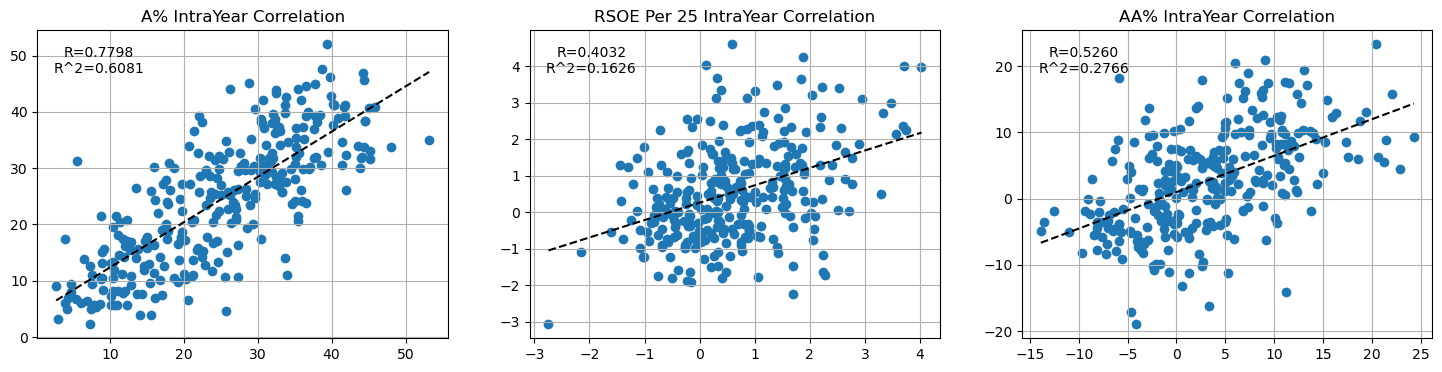

In [12]:
# Get first-half data
df = adv_tackling_scoreboard.loc[adv_tackling_scoreboard['week']==0,['Player','Position','RSOE Per 25','Approach %','Added Approach %','Expected Approach %','Expected Run Stop %']]

# Merage in second-half data
df = df.merge(
    how='left',
    on=['Player','Position'],
    right=adv_tackling_scoreboard.loc[adv_tackling_scoreboard['week']==1,['Player','Position','RSOE Per 25','Approach %','Added Approach %','Expected Approach %','Expected Run Stop %']],
    suffixes=(' - 0',' - 1')
)

# Approach percentage correlation
fig, ax = plt.subplots(1,3,figsize=(18,4))
mask = (df['Approach % - 0'].notnull()) & (df['Approach % - 1'].notnull())
slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[mask,'Approach % - 0'], df.loc[mask,'Approach % - 1'])
x = np.array([df.loc[mask,'Approach % - 0'].min(), df.loc[mask,'Approach % - 0'].max()])
ax[0].scatter(df['Approach % - 0'],df['Approach % - 1'])
ax[0].plot(x,slope*x + intercept, 'k--')
ax[0].grid('minor')
ax[0].set_title('A% IntraYear Correlation')
ax[0].text(0.15, 0.9, f"R={r_value:0.4f}\nR^2={r_value**2:0.4f}",horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes) 

# RSOE per 25 correlation
mask = (df['RSOE Per 25 - 0'].notnull()) & (df['RSOE Per 25 - 1'].notnull())
slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[mask,'RSOE Per 25 - 0'], df.loc[mask,'RSOE Per 25 - 1'])
x = np.array([df.loc[mask,'RSOE Per 25 - 0'].min(), df.loc[mask,'RSOE Per 25 - 0'].max()])
ax[1].scatter(df['RSOE Per 25 - 0'],df['RSOE Per 25 - 1'])
ax[1].plot(x,slope*x + intercept, 'k--')
ax[1].grid('minor')
ax[1].set_title('RSOE Per 25 IntraYear Correlation')
ax[1].text(0.15, 0.9, f"R={r_value:0.4f}\nR^2={r_value**2:0.4f}",horizontalalignment='center',verticalalignment='center', transform=ax[1].transAxes) 

# Added approach % correlation
mask = (df['Added Approach % - 0'].notnull()) & (df['Added Approach % - 1'].notnull())
slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[mask,'Added Approach % - 0'], df.loc[mask,'Added Approach % - 1'])
x = np.array([df.loc[mask,'Added Approach % - 0'].min(), df.loc[mask,'Added Approach % - 0'].max()])
ax[2].scatter(df['Added Approach % - 0'],df['Added Approach % - 1'])
ax[2].plot(x,slope*x + intercept, 'k--')
ax[2].grid('minor')
ax[2].set_title('AA% IntraYear Correlation')
ax[2].text(0.15, 0.9, f"R={r_value:0.4f}\nR^2={r_value**2:0.4f}",horizontalalignment='center',verticalalignment='center', transform=ax[2].transAxes) 
fig.show()